# Learning and Decision Making

## Laboratory 5: Reinforcement learning

In the end of the lab, you should export the notebook to a Python script (File >> Download as >> Python (.py)). Your file should be named `padi-lab5-groupXX.py`, where the `XX` corresponds to your group number and should be submitted to the e-mail <adi.tecnico@gmail.com>. 

Make sure...

* **... that the subject is of the form `[<group n.>] LAB <lab n.>`.** 

* **... to strictly respect the specifications in each activity, in terms of the intended inputs, outputs and naming conventions.** 

In particular, after completing the activities you should be able to replicate the examples provided (although this, in itself, is no guarantee that the activities are correctly completed).

### 1. The MDP Model 

In this lab you will implement several reinforcement learning algorithms, and use the "Doom" domain, from Lab 2, to test and compare these algorithms. Don't forget, however, that your functions should work for **any MDP** and not just the one provided. 

The "Doom" domain to be used is represented in the diagram below.

<img src="maze.png" width="400px">

In the doom domain above,

* The agent can move in any of the four directions: up, down, left, and right. 
* Movement across a grey cell division succeeds with a 0.8 probability and fails with a 0.2 probability. 
* Movements across colored cell divisions (blue or red) succeed with a 0.8 probability (and fail with a probability 0.2) only if the agent has the corresponding colored key. Otherwise, they fail with probability 1. To get a colored key, the agent simply needs to stand in the corresponding cell.
* When the movement fails, the agent remains in the same cell. 
* The action that takes the agent through the exit always succeeds.  

We consider that the agent is never in a cell $c\geq 17$ without a red key, and is never in a cell $c\geq28$ without a blue key. **Throughout the lab, unless if stated otherwise, use $\gamma=0.9$.**

$$\diamond$$

We start by loading the MDP for the "Doom" domain from the file `doom.npz`. We will use this domain as an example to illustrate the different functions/algorithms you are expected to deploy. The file contains both the MDP, described as a tuple like those from Lab 2, and the corresponding optimal $Q$-function.

To do so, you can run the code
```python
import numpy as np

mdp_info = np.load('doom.npz', allow_pickle=True)

# The MDP is a tuple (X, A, P, c, gamma)
M = mdp_info['M']

# We also load the optimal Q-function for the MDP
Qopt = mdp_info['Q']
```

---

In the first activity, you will implement a function that enables you to sample a transition from a given MDP. You will then use this function, in subsequent activities, to generate the data that your agent will use to learn.

---

#### Activity 1.        

Write a function named `sample_transition` that receives, as input, a tuple representing an arbitrary MDP as well as two integers, `s` and `a`, corresponding to a state and an action. The function should return a tuple `(s, a, c, s')`, where `c` is the cost associated with performing action `a` in state `s` and `s'` is a state generated from `s` upon selecting action `a`, according to the transition probabilities for the MDP.

**Note:** Don't forget to import `numpy.random` to generate the state `s'`.

---

In [89]:
import numpy as np
import numpy.random as rnd

def sample_transition(mdp,s,a):
    c = mdp[3][s][a]
    
    P = mdp[2][a][s]
    s_ = rnd.choice(range(len(P)), p=P)
    
    return (s, a, c, s_)



mdp_info = np.load('doom.npz', allow_pickle=True)

# The MDP is a tuple (X, A, P, c, gamma)
M = mdp_info['M']

# We also load the optimal Q-function for the MDP
Qopt = mdp_info['Q']

rnd.seed(42)

# Select random state and action
s = rnd.randint(len(M[0]))
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('Observed transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')

# Select random state and action
s = rnd.randint(len(M[0]))
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('Observed transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')

# Select random state and action
s = rnd.randint(len(M[0]))
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('Observed transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')

Observed transition:
(9RB, u, 1.0, 9RB)
Observed transition:
(29RB, u, 1.0, 29RB)
Observed transition:
(8R, l, 1.0, 8R)


All reinforcement learning algorithms that you will implement can only access the MDP through the function `sample_transition` which, in a sense, simulates an "interaction" of the agent with the environment.

For example, using the "Doom" MDP, you could run:

```python
import numpy.random as rnd

rnd.seed(42)

# Select random state and action
s = rnd.randint(len(M[0]))
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('Observed transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')

# Select random state and action
s = rnd.randint(len(M[0]))
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('Observed transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')

# Select random state and action
s = rnd.randint(len(M[0]))
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('Observed transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')
```

and get, as output:

```
Observed transition:
(9RB, u, 1.0, 9RB)
Observed transition:
(29RB, u, 1.0, 29RB)
Observed transition:
(8R, l, 1.0, 8R)
```

---

#### Activity 2.        

Write down a function named `egreedy` that implements an $\epsilon$-greedy policy. Your function should receive, as input, a `numpy` array `Q` with shape `(N,)`, for some integer $N$, and, as an optional argument, a floating point number `eps` with a default value `eps=0.1`. Your function should return... 

* ... with a probability $\epsilon$, a random index between $0$ and $N-1$.
* ... with a probability $1-\epsilon$, the index between $0$ and $N-1$ corresponding to the minimum value of `Q`. If more than one such index exists, the function should select among such indices **uniformly at random**.

In [90]:
def egreedy(Q,eps=0.1):
    index = 0
    if rnd.uniform() < eps:
        index = rnd.randint(len(Q)) 
    else:
        minIndexes = np.where(Q == np.amin(Q))
        
        index = rnd.choice(range(len(minIndexes)))
        index = minIndexes[index][0]
    
        rnd.rand() # <- what?

    return index

rnd.seed(42)

s = 51
a = egreedy(Qopt[s, :], eps=0)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action:', M[1][a])

s = 71
a = egreedy(Qopt[s, :], eps=0)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action:', M[1][a])

s = 23
a = egreedy(Qopt[s, :], eps=0)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action:', M[1][a])

State: 9RB - action: l
State: 9RB - action: l
State: 9RB - action: l
State: 29RB - action: r
State: 29RB - action: r
State: 29RB - action: d
State: 8R - action: u
State: 8R - action: u
State: 8R - action: u


For example, using the function `Qopt` loaded from the "Doom" file, you can run:

```python
rnd.seed(42)

s = 51
a = egreedy(Qopt[s, :], eps=0)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action:', M[1][a])

s = 71
a = egreedy(Qopt[s, :], eps=0)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action:', M[1][a])

s = 23
a = egreedy(Qopt[s, :], eps=0)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action:', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action:', M[1][a])
```

you will get the output

```
State: 9RB - action: l
State: 9RB - action: l
State: 9RB - action: l
State: 29RB - action: r
State: 29RB - action: r
State: 29RB - action: d
State: 8R - action: u
State: 8R - action: u
State: 8R - action: u
```

---

#### Activity 3. 

Write a function `mb_learning` that implements the model-based reinforcement learning algorithm discussed in class. Your function should receive as input arguments 

* A tuple, `mdp`, containing the description of an **arbitrary** MDP. The structure of the tuple is similar to that provided in the example above. 
* An integer, `n`, corresponding he number of steps that your algorithm should run.
*  A numpy array `qinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `qinit` should be used to initialize the $Q$-function being learned by your function.
* A tuple, `Pinit`, with as many elements as the number of actions in `mdp`. Each element of `Pinit` corresponds to square numpy arrays with as many rows/columns as the number of states in `mdp` and can be **any** transition probability matrix. The matrices in `Pinit` should be used to initialize the transition probability matrices of the model being learned by your function.
* A numpy array `cinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `cinit` should be used to initialize the cost function of the model being learned by your function.

Your function should simulate an interaction of `n` steps between the agent and the environment, during which it should perform `n` iterations of the model-based RL algorithm seen in class. In particular, it should learn the transition probabilities and cost function from the interaction between the agent and the environment, and use these to compute the optimal $Q$-function. The transition probabilities, cost and $Q$-functions to be learned should be initialized using `Pinit`, `cinit` and `qinit`, respectively. 

Note that, at each step of the interaction,

* The agent should observe the current state, and select an action using an $\epsilon$-greedy policy with respect to its current estimate of the optimal $Q$-values. You should use the function `egreedy` from Activity 2, with $\epsilon=0.15$. 
* Given the state and action, you must then compute the cost and generate the next state, using `mdp` and the function `sample_transition` from Activity 1.
* With this transition information (state, action, cost, next-state), you can now perform an update to the transition probabilities, cost function, and $Q$-function.
* When updating the components $(x,a)$ of the model, use the step-size

$$\alpha_t=\frac{1}{N_t(x,a)+1},$$

where $N_t(x,a)$ is the number of visits to the pair $(x,a)$ up to time step $t$.

Your function should return a tuple containing:

*  A numpy array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned $Q$-function.
* A tuple with as many elements as the number of actions in `mdp`. The element $a$ of the tuple corresponds to a square numpy array with as many rows/columns as the number of states in `mdp`, corresponding to the learned transition probabilities for action $a$.
* A numpy array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned cost function.

---

In [103]:
def mb_learning(mdp, n, qinit, Pinit, cinit):
    P = list(Pinit)
    c = cinit
    q = qinit
    s = rnd.choice(range(len(mdp[0])))
    
    gama = mdp[-1]
    
    N = np.zeros((len(mdp[0]),len(mdp[1])))
    #N = {}
    for i in range (n):        
        action = egreedy(q[s, :],0.15)
        (s, a, c_, s_) = sample_transition(mdp,s,action)

        #if (s,a) in N:
        #    N[(s,a)] += 1
        #else:
        #    N[(s,a)] = 1       
        
        alfa = 1/(N[s][a]+1)
        N[s][a] += 1
        
        # Update c
        c[s][a] = c[s][a] + alfa*(c_ - c[s][a])
        
        # Update P
        tempP = P[a][s][s_]
        P[a][s][:] += alfa * (0 - P[a][s][:])
        P[a][s][s_] = tempP + alfa * (1 - tempP)                

        # Update Q
        q[s][a] = c[s][a] + gama * P[a][s][:].dot(np.min(q, axis=1, keepdims=True))
        
        #som = 0
        #for y in range(len(mdp[0])):
        #    som += P[a][s][y] * np.min(q[y])
        #q[s][a] = c[s][a] + gama * som

        #for x in range(len(mdp[0])):
        #    for a in range(len(mdp[1])):
        #        som = 0
        #        for y in range(len(mdp[0])):
        #            som += P[a][x][y] * np.min(q[y])
        #        q[x][a] = c[x][a] + gama * som
          
        s = s_

    return (q,tuple(P),c)
        
rnd.seed(42)

# Initialize transition probabilities
pinit = ()

for a in range(len(M[1])):
    pinit += (np.eye(len(M[0])),)

# Initialize cost function
cinit = np.zeros((len(M[0]), len(M[1])))

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qinit, pinit, cinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qnew, pnew, cnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))

Error in Q after 1000 steps: 137.54318835284175
Error in Q after 2000 steps: 131.7820490413184


As an example using the "Doom" MDP, we could run:

```python
rnd.seed(42)

# Initialize transition probabilities
pinit = ()

for a in range(len(M[1])):
    pinit += (np.eye(len(M[0])),)

# Initialize cost function
cinit = np.zeros((len(M[0]), len(M[1])))

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qinit, pinit, cinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qnew, pnew, cnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))
```

to get

```
Error in Q after 1000 steps: 140.3680056014355
Error in Q after 2000 steps: 136.6988053714166
```

Note that, even if the seed is fixed, the numerical values may differ somewhat from those above.

### 3. Model-free learning

You will now implement both $Q$-learning and SARSA.

---

#### Activity 4. 

Write a function `qlearning` that implements the $Q$-learning algorithm discussed in class. Your function should receive as input arguments 

* A tuple, `mdp`, containing the description of an **arbitrary** MDP. The structure of the tuple is similar to that provided in the examples above. 
* An integer, `n`, corresponding he number of steps that your algorithm should run.
*  A `numpy` array `qinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `qinit` should be used to initialize the $Q$-function being learned by your function.

Your function should simulate an interaction of `n` steps between the agent and the environment, during which it should perform `n` iterations of the $Q$-learning algorithm seen in class. In particular, it should learn optimal $Q$-function. The $Q$-function to be learned should be initialized using `qinit`. 

Note that, at each step of the interaction,

* The agent should observe the current state, and select an action using an $\epsilon$-greedy policy with respect to its current estimate of the optimal $Q$-values. You should use the function `egreedy` from Activity 2, with $\epsilon=0.15$. 
* Given the state and action, you must then compute the cost and generate the next state, using `mdp` and the function `sample_transition` from Activity 1.
* With this transition information (state, action, cost, next-state), you can now perform an update to the $Q$-function.
* When updating the components $(x,a)$ of the model, use the step-size $\alpha=0.3$.

Your function should return a `numpy` array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned $Q$-function.

---

In [96]:
def qlearning(mdp,n,qinit):
    q = qinit
    s = rnd.choice(range(len(mdp[0])))
    gama = mdp[-1]
    
    alfa = 0.3
    for i in range (n):        
        action = egreedy(q[s, :],0.15)
        (s, a, c_, s_) = sample_transition(mdp,s,action)

        # Update Q
        q[s][a] = q[s][a] + alfa * (c_ + gama * np.min(q[s_])-q[s][a])
        
        s = s_
    
    return q
    
rnd.seed(42)
# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = qlearning(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = qlearning(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))

Error in Q after 1000 steps: 134.20733065848333
Error in Q after 2000 steps: 132.4522327000934


As an example using the "Doom" MDP, we could run:

```python
rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = qlearning(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = qlearning(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))
```

to get

```
Error in Q after 1000 steps: 140.64048831542058
Error in Q after 2000 steps: 136.03209355140416
```

Once again, even if the seed is fixed, the numerical values may differ somewhat from those above.

---

#### Activity 5. 

Write a function `sarsa` that implements the SARSA algorithm discussed in class. Your function should receive as input arguments 

* A tuple, `mdp`, containing the description of an **arbitrary** MDP. The structure of the tuple is similar to that provided in the examples above. 
* An integer, `n`, corresponding he number of steps that your algorithm should run.
*  A `numpy` array `qinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `qinit` should be used to initialize the $Q$-function being learned by your function.

Your function should simulate an interaction of `n` steps between the agent and the environment, during which it should perform `n` iterations of the SARSA algorithm seen in class. The $Q$-function to be learned should be initialized using `qinit`. 

Note that, at each step of the interaction,

* The agent should observe the current state, and select an action using an $\epsilon$-greedy policy with respect to its current estimate of the optimal $Q$-values. You should use the function `egreedy` from Activity 2, with $\epsilon=0.15$. **Do not adjust the value of $\epsilon$ during learning.**
* Given the state and action, you must then compute the cost and generate the next state, using `mdp` and the function `sample_transition` from Activity 1.
* With this transition information (state, action, cost, next-state), you can now perform an update to the $Q$-function.
* When updating the components $(x,a)$ of the model, use the step-size $\alpha=0.3$.

Your function should return a `numpy` array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned $Q$-function.

---

In [93]:
def sarsa(mdp, n, qinit):
    q = qinit
    s = rnd.choice(range(len(mdp[0])))
    gama = mdp[-1]
    
    alfa = 0.3
    for i in range (n):        
        if i == 0:
            action = egreedy(q[s, :],0.15)
        else:
            action = next_action
            
        (s, a, c_, s_) = sample_transition(mdp,s,action)
        next_action = egreedy(q[s_, :],0.15)
        a_ = next_action

        # Update Q
        q[s][a] = q[s][a] + alfa * (c_ + gama * q[s_][a_]-q[s][a])
        
        s = s_
    
    return q

rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = sarsa(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = sarsa(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))

Error in Q after 1000 steps: 133.95529664804835
Error in Q after 2000 steps: 131.08115974315487


As an example using the "Doom" MDP, we could run:

```python
rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = sarsa(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = sarsa(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))
```

to get

```
Error in Q after 1000 steps: 136.89677001743058
Error in Q after 2000 steps: 133.63203126530152
```

You can also run the following code, to compare the performance of the three methods.

```python
%matplotlib inline

import matplotlib.pyplot as plt

STEPS = 10
ITERS = 1000
RUNS  = 10

iters = range(0, STEPS * ITERS + 1, STEPS)

# Error matrices
Emb = np.zeros(ITERS + 1)
Eql = np.zeros(ITERS + 1)
Ess = np.zeros(ITERS + 1)

Emb[0] = np.linalg.norm(Qopt) * RUNS
Eql[0] = Emb[0]
Ess[0] = Emb[0]

for n in range (RUNS):

    # Initialization
    pmb = ()
    for a in range(len(M[1])):
        pmb += (np.eye(len(M[0])),)
    cmb = np.zeros((len(M[0]), len(M[1])))
    qmb = np.zeros((len(M[0]), len(M[1])))

    qql = np.zeros((len(M[0]), len(M[1])))

    qss = np.zeros((len(M[0]), len(M[1])))

    # Run evaluation
    for t in range(ITERS):
        qmb, pmb, cmb = mb_learning(M, STEPS, qmb, pmb, cmb)
        Emb[t + 1] += np.linalg.norm(Qopt - qmb)

        qql = qlearning(M, STEPS, qql)
        Eql[t + 1] += np.linalg.norm(Qopt - qql)

        qss = sarsa(M, STEPS, qss)
        Ess[t + 1] += np.linalg.norm(Qopt - qss)
        
Emb /= RUNS
Eql /= RUNS
Ess /= RUNS

plt.figure()
plt.plot(iters, Emb, label='Model based learning')
plt.plot(iters, Eql, label='Q-learning')
plt.plot(iters, Ess, label='SARSA')
plt.legend()
plt.xlabel('N. iterations')
plt.ylabel('Error in $Q$-function')
```

As the output, you should observe the following plot.

<img src="plot.png" align="left">

Text(0, 0.5, 'Error in $Q$-function')

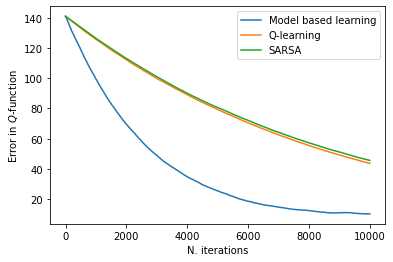

In [105]:
%matplotlib inline

import matplotlib.pyplot as plt

STEPS = 10
ITERS = 1000
RUNS  = 10

iters = range(0, STEPS * ITERS + 1, STEPS)

# Error matrices
Emb = np.zeros(ITERS + 1)
Eql = np.zeros(ITERS + 1)
Ess = np.zeros(ITERS + 1)

Emb[0] = np.linalg.norm(Qopt) * RUNS
Eql[0] = Emb[0]
Ess[0] = Emb[0]

for n in range (RUNS):

    # Initialization
    pmb = ()
    for a in range(len(M[1])):
        pmb += (np.eye(len(M[0])),)
    cmb = np.zeros((len(M[0]), len(M[1])))
    qmb = np.zeros((len(M[0]), len(M[1])))

    qql = np.zeros((len(M[0]), len(M[1])))

    qss = np.zeros((len(M[0]), len(M[1])))

    # Run evaluation
    for t in range(ITERS):
        qmb, pmb, cmb = mb_learning(M, STEPS, qmb, pmb, cmb)
        Emb[t + 1] += np.linalg.norm(Qopt - qmb)

        qql = qlearning(M, STEPS, qql)
        Eql[t + 1] += np.linalg.norm(Qopt - qql)

        qss = sarsa(M, STEPS, qss)
        Ess[t + 1] += np.linalg.norm(Qopt - qss)

Emb /= RUNS
Eql /= RUNS
Ess /= RUNS

plt.figure()
plt.plot(iters, Emb, label='Model based learning')
plt.plot(iters, Eql, label='Q-learning')
plt.plot(iters, Ess, label='SARSA')
plt.legend()
plt.xlabel('N. iterations')
plt.ylabel('Error in $Q$-function')

---

#### Activity 6.

Discuss the differences observed between the performance of the three methods.

---

<span style="color:blue">
    Firstly, let's start by explaining the theoretical difference between each of these implementations. <br>
    Model-Based Reinforcement Learning attempts to learn the optimal behaviours indirectly, by instead examining a model of the environment by taking actions and observing the outcomes produced by applying the selected action to the current state and the corresponding immediate reward. <br>
    Q-Learning, on the other hand, aims to find an optimal policy by maximizing the expected value of the total reward over any and all successive steps, starting from the current state. <br>
    SARSA - State, Action, Reinforcement, (Next) State, (Next) Action - works similarly to Q-Learning, but takes into consideration, when computing the new optimal Q-values, not only the current state, action and next state, but also the next action. A main difference between this and Q-Learning is that the latter is an off-policy algorithm, i.e, it learns the value of one policy while following another, whilst the first is an on-policy algorithm (it learns the value of the policy that it follows). <br><br>
    Looking at our results, in terms of performance quality, the graph shown above (and the sanity values obtained when running the algorithms) showed that, Q-Learning and SARSA produced very similar Q-Function errors at each number of iterations, with SARSA showcasing very slightly higher values (i.e worse). Meanwhile Model-Based Learning managed much smaller errors in way less numbers of iterations, managing to start stabilizing at around ~7000 iteration, whilst the other two algorithms seem to require more iterations to reach a stable plateau. SARSA does seem to start stabilizing a bit sooner than Q-Learning, noted by the deviation from Q-Learning that can be seen at around 10000 iterations. <br>
    In terms of time performance we did note that Model-Based does tend to take a bit longer to execute whilst the other two algorithms run marginally faster than the aformentioned, and very similarly to each other.
    
</span>